Задача: классифицировать комментарии на позитивные и негативные для целей модерации.

## Подготовка

Краткий словарь:

- Лемматизация - процесс преобразования слова в его базовую форму.

- Токенизация - процесс разделения письменного языка на предложения-компоненты либо слова-компоненты.

- Эмбеддинги слов - числовые векторы, полученные из слов.

- Стоп-слова – это слова, которые выкидываются из текста до/после обработки текста.

Установим необходимые пакеты:

In [ ]:
!pip install transformers

Импортируем необходимые библиотеки:

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch
import transformers

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
from pymystem3 import Mystem
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import notebook
import tarfile
from IPython.display import display
import warnings

warnings.simplefilter("ignore") #будем игнорировать предупреждения
SEED = 42 #определяем константу, которая будет инициировать случайные числа

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Подключим GPU:

In [ ]:
torch.cuda.is_available()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Подключим google-disk:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим данные и посмотрим на них. Т.к. данных очень много, облегчим нагрузку на ресурсы и сделаем случайную выборку из 50000 строк.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Yandex_datasets/toxic_comments.csv').sample(50000, random_state = SEED)
print(display(data.head()))
print(data.info())

,text,toxic
119105,"Geez, are you forgetful! We've already discus...",0
131631,Carioca RFA \n\nThanks for your support on my ...,0
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0
111256,Pseudoscience category? \n\nI'm assuming that ...,0
83590,"(and if such phrase exists, it would be provid...",0


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 119105 to 52099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   toxic   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


Предварительно скачав претренированную модель Bert для Pytorch (диалоги) с сайта лаборатории DeepPavlov http://docs.deeppavlov.ai/en/master/features/models/bert.html, распакуем архив.

In [ ]:
tar = tarfile.open('/content/drive/MyDrive/Yandex_datasets/conversational_cased_L-12_H-768_A-12_pt.tar.gz')
tar.extractall()
tar.close()

## Обучение

### Модель 1 - `bert-base-cased`

Произведем токенизацию с помощью Bert, предварительно загрузив файл словаря претренированной модели `bert-base-cased`. Максимальная длина токена в модели 512, поэтому мы не сможем работать с большей длиной. Установим ее и создадим пэддинг (пустые поля) у более коротких токенов. Далее пропишем маску.

In [ ]:
max_len = 512
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=max_len))


padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Загрузим претренерованную модель, подключив ее к GPU.

In [ ]:
model_bert = transformers.BertModel.from_pretrained('bert-base-cased').to(device)


Установим размер батча, получим батчи и маски в формате тензоров, "скормим" их модели Bert и получим список эмбеддингов. Торч-тензоры будем отправлять на GPU, финальный список эмбеддингов отправим обратно на CPU и сделаем массивом numpy.

In [ ]:
batch_size = 128
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size - 1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())

Напишем функцию для тренировки и предсказаний регрессионной модели:

In [ ]:
def fit_predict(model, features_train, target_train, features_test, target_test):
  model.fit(features_train, target_train)
  pred = model.predict(features_test)
  f1 = f1_score(target_test, pred)
  print('f1 score =', f1)
  return f1, pred

Сделаем из эмбеддингов фичи. Обозначим таргет. Разделим данные на тренировочную и тестовую выборки.

In [ ]:
features_1 = np.concatenate(embeddings)
target_1 = data['toxic'][0:len(embeddings)*batch_size]
features_train_1, features_test_1, target_train_1, target_test_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=SEED)

Создадим таблицу, в которую будем записывать результаты:

In [ ]:
score_table = pd.DataFrame(columns = ['f1', 'model_embeddings', 'model_regression'])
index = 0
type_emb='bert-base'

Создадим функцию, которая будет строить разные регрессионные модели и выдавать результаты в таблицу:

In [ ]:
def regr_models(score_table, type_emb, features_train, target_train, features_test, target_test, index):

  #Построим модель логистической регрессии, обучим ее, результат запишем в таблицу:
  model = LogisticRegression()
  score_table.loc[index, 'f1'], _ = fit_predict(model, features_train, target_train, features_test, target_test)
  score_table.loc[index, 'model_embeddings'] = type_emb
  score_table.loc[index, 'model_regression'] = 'log_regression'
  index +=1

  #Построим модель случайного леса, обучим ее, результат запишем в таблицу:
  model = RandomForestClassifier(random_state = SEED)
  score_table.loc[index, 'f1'], _ = fit_predict(model, features_train, target_train, features_test, target_test)
  score_table.loc[index, 'model_embeddings'] = type_emb
  score_table.loc[index, 'model_regression'] = 'random_forest'
  index +=1

  #Построим модель градиентного бустинга, обучим ее, результат запишем в таблицу:
  model = LGBMClassifier(random_state = SEED)
  score_table.loc[index, 'f1'], _ = fit_predict(model, features_train, target_train, features_test, target_test)
  score_table.loc[index, 'model_embeddings'] = type_emb
  score_table.loc[index, 'model_regression'] = 'gradient_boosting'
  index +=1

  #Построим константную модель, обучим ее, результат запишем в таблицу:
  model = DummyClassifier(random_state=SEED)
  score_table.loc[index, 'f1'], _ = fit_predict(model, features_train, target_train, features_test, target_test)
  score_table.loc[index, 'model_embeddings'] = type_emb
  score_table.loc[index, 'model_regression'] = 'dummy'
  index +=1

  return score_table, index

Используем эту функцию:

In [ ]:
score_table, index = regr_models(score_table, type_emb, features_train_1, target_train_1, features_test_1, target_test_1, index)

f1 score = 0.6961471103327496
f1 score = 0.44659090909090904
f1 score = 0.6231816048803379
f1 score = 0.0949367088607595


### Модель 2 - `bert: conversational_cased`

Проделаем все те же операции, загрузив другую, предварительно скачанную модель `conversational_cased` для `pytorch`.

In [ ]:
tokenizer = transformers.BertTokenizer(
    vocab_file='/content/conversational_cased_L-12_H-768_A-12_pt/vocab.txt')

tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=max_len))


padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
config = transformers.BertConfig.from_json_file(
    '/content/conversational_cased_L-12_H-768_A-12_pt/bert_config.json')

model_bert = transformers.BertModel.from_pretrained(
    '/content/conversational_cased_L-12_H-768_A-12_pt/pytorch_model.bin', config=config).to(device)

In [ ]:
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size - 1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())

In [ ]:
features_2 = np.concatenate(embeddings)
target_2 = data['toxic'][0:len(embeddings)*batch_size]
features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=SEED)
type_emb='bert-conversational'
score_table, index = regr_models(score_table, type_emb, features_train_2, target_train_2, features_test_2, target_test_2, index)

f1 score = 0.7302798982188294
f1 score = 0.4499424626006904
f1 score = 0.644475265834489
f1 score = 0.0949367088607595


### Модель 3 - `tf-idf`

Теперь воспользуемся методом TF-IDF. Будем создавать заново фичи. Сперва токенизируем и лемматизируем наш текст, результат запишем в два новых столбца таблицы для удобства, составим корпус:

In [ ]:
model_lemma = WordNetLemmatizer()

def tokenize(text):
  return nltk.word_tokenize(text.lower())

def lemmatize(token_list):
  lem_list = []
  for token in token_list:
    lem_list.append(model_lemma.lemmatize(token))
  lem_list = ' '.join(lem_list)
  lem_list = re.sub(r'[^a-zA-Z]', ' ', lem_list)
  
  return lem_list

data['token_text']=data['text'].apply(tokenize)
data['lemm_text']=data['token_text'].apply(lemmatize)
corpus = data['lemm_text'].values.astype('U')
print(display(data.head()))

,text,toxic,token_text,lemm_text
119105,"Geez, are you forgetful! We've already discus...",0,"[geez, ,, are, you, forgetful, !, we, 've, alr...",geez are you forgetful we ve already disc...
131631,Carioca RFA \n\nThanks for your support on my ...,0,"[carioca, rfa, thanks, for, your, support, on,...",carioca rfa thanks for your support on my requ...
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,"[``, birthday, no, worries, ,, it, 's, what, i...",birthday no worry it s what i do enj...
111256,Pseudoscience category? \n\nI'm assuming that ...,0,"[pseudoscience, category, ?, i, 'm, assuming, ...",pseudoscience category i m assuming that th...
83590,"(and if such phrase exists, it would be provid...",0,"[(, and, if, such, phrase, exists, ,, it, woul...",and if such phrase exists it would be prov...


None


Загрузим словарь стоп-слов и, исключая их, запустим модель TF-IDF векторизации на нашем корпусе.


In [ ]:
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf= count_tf_idf.fit_transform(corpus)

Теперь фичами будут являться результаты работы TF-IDF, разобьем данные на тренировочные и тестовые:

In [ ]:
features_3 = tf_idf[0:len(embeddings)*batch_size]
target_3 = data['toxic'][0:len(embeddings)*batch_size]
features_train_3, features_test_3, target_train_3, target_test_3 = train_test_split(features_3, target_3, test_size=0.25, random_state=SEED)

Построим модель логистической регрессии, случайного леса, градиентного бустинга и константную, обучим их, результаты запишем в таблицу:

In [ ]:
type_emb='tf-idf'
score_table, index = regr_models(score_table, type_emb, features_train_3, target_train_3, features_test_3, target_test_3, index)

f1 score = 0.637922077922078
f1 score = 0.681840672934191
f1 score = 0.7341655108645401
f1 score = 0.0949367088607595


Таблица результатов:

In [ ]:
print(display(score_table))

,f1,model_embeddings,model_regression
0,0.696147,bert-base,log_regression
1,0.446591,bert-base,random_forest
2,0.623182,bert-base,gradient_boosting
3,0.0949367,bert-base,dummy
4,0.73028,bert-conversational,log_regression
5,0.449942,bert-conversational,random_forest
6,0.644475,bert-conversational,gradient_boosting
7,0.0949367,bert-conversational,dummy
8,0.637922,tf-idf,log_regression
9,0.681841,tf-idf,random_forest


None


### Модель 4 - ensemble

Построим рейтинг моделей, исходя из полученной метрики `f1`:

In [ ]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(5,5))
    cmap = ListedColormap(sns.color_palette("GnBu_d"))
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(ch), xy=(ch if ch>0 else 0, p), va='center')

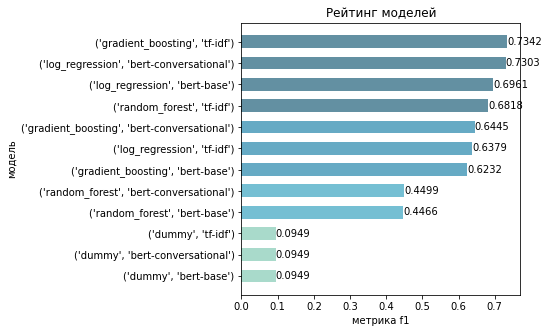

In [ ]:
ranking(score_table.groupby(['model_regression', 'model_embeddings'])['f1'].aggregate('max').sort_values(ascending = False), 'Рейтинг моделей', 'метрика f1', 'модель')

Возьмем 3 лучшие модели:

In [ ]:
model = LogisticRegression()
_, pred_1 = fit_predict(model, features_train_1, target_train_1, features_test_1, target_test_1)
model = LogisticRegression()
_, pred_2 = fit_predict(model, features_train_2, target_train_2, features_test_2, target_test_2)
model = LGBMClassifier(random_state = SEED)
_, pred_3 = fit_predict(model, features_train_3, target_train_3, features_test_3, target_test_3)

f1 score = 0.6961471103327496
f1 score = 0.7302798982188294
f1 score = 0.7341655108645401


Теперь составим из 3 лучших моделей ансамбль. В качестве результата работы ансамбля будем брать тот результат, который совпадает у двух любых моделей:

In [ ]:

def emsemble(pred_1, pred_2, pred_3):
  pred = pred_1
  for i in range(0,len(target_test_1)):
    if pred_1[i] == pred_2[i] or pred_1[i] == pred_3[i]:
      pred[i] = pred_1[i]
    else:
      pred[i] = pred_2[i]
  return pred 


In [ ]:
pred = emsemble(pred_1, pred_2, pred_3)
f1 = f1_score(target_test_1, pred)
print('f1 score =', f1)
score_table.loc[index, 'f1']= f1
score_table.loc[index, 'model_embeddings'] = 'ensemble'
score_table.loc[index, 'model_regression'] = 'ensemble'

f1 score = 0.7509057971014492


Составим рейтинг 4 лучших моделей, включая ансамбль. Видно, что ансамбль имеет лучший результат и его метрика `f1` выше требуемого задачей порога 0.75.

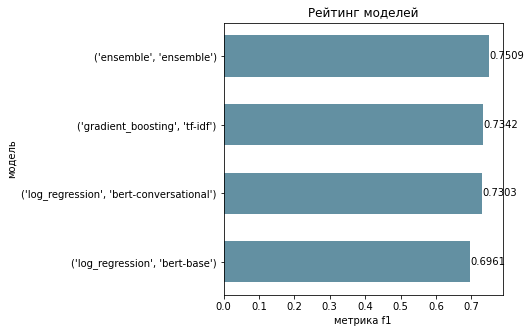

In [ ]:
ranking(score_table.groupby(['model_regression', 'model_embeddings'])['f1'].aggregate('max').sort_values(ascending = False).head(4), 'Рейтинг моделей', 'метрика f1', 'модель')

## Выводы

- Мы установили необходимые пакеты и импортировали необходимые библиотеки. Подключили GPU.

- Мы загрузили данные и изучили их. Т.к. данных очень много, облегчили нагрузку на ресурсы и сделали случайную выборку из 50000 строк.

- Предварительно скачав претренированную модель Bert для Pytorch (диалоги) с сайта лаборатории DeepPavlov, распаковали архив.

- Произвели токенизацию с помощью Bert, предварительно загрузив файл словаря претренированной модели `bert-base-cased`. Максимальная длина токена в модели 512. Установили ее и создали пэддинг (пустые поля) у более коротких токенов. Прописали маску.

- Загрузили претренерованную модель, подключив ее к GPU.

- Установили размер батча, получили батчи и маски в формате тензоров, выдали их модели Bert в качестве параметров и получили список эмбеддингов. Торч-тензоры мы отправляли на GPU, финальный список эмбеддингов - обратно на CPU.

- Сделали из эмбеддингов фичи. Обозначили таргет. Разделили данные на тренировочную и тестовую выборки.

- Написали функцию для тренировки и предсказаний регрессионной модели, также функцию, которая будет строить разные регрессионные модели и выдавать результаты в таблицу, создали таблицу для результатов.

- Получили предсказания и метрики качества `f1` моделей логистической регрессии, случайного леса, градиентного бустинга и константной для данной модели bert. Результаты записали в таблицу.

- Повторили действия и получили предсказания и метрики качества для другой модели bert, загруженной локально. Результаты записали в таблицу.

- Создали токены и леммы для наших текстов для дальнейшего использования в модели `tf-idf`, составили корпус текстов.

- Загрузили словарь стоп-слов и, исключая их, запустили модель TF-IDF векторизации на нашем корпусе.

- Использовали в качестве новых фичей результаты работы TF-IDF, разбили данные на тренировочные и тестовые. Получили предсказания и метрики качества моделей логистической регрессии, случайного леса, градиентного бустинга и константной для данных `tf-idf`. Результаты записали в таблицу.

- Посмотрели на полученную таблицу, построили рейтинг моделей исходя из метрики `f1`.

- Можно заметить, что лучшие значения метрики для моделей bert дает логистическая регрессия, для моделей tf-idf - градиентный бустинг и случайный лес.

- Выбрали 3 лучшие модели и составили из них ансамбль.

- Путем голосования получили результаты работы ансамбля. 

- Вывели рейтинг 4-х лучших моделей, включая ансамбль. Лучшее значение метрики качества `f1 = 0.7509` - у ансамбля. 

